In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable

from sklearn import preprocessing

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

import numpy as np
import pandas as pd

In [2]:
EPOCHS = 50
BATCH_SIZE = 10
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.005
HIDDEN_DIM = 5
GRADIENT_CLIP = 10
DROPOUT_PARAM = 0

In [3]:
class TwoGramLanguageModeler(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(TwoGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)
    
    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

In [4]:
data = pd.read_csv('../data/SMSSpamCollection', sep='\t', header=None)
data['Text'] = data[1].str.replace('[^\w\s]','')
data.columns = ['label', 'Full Text', 'Text']
data['Lower Case Text'] = data['Text'].str.lower()

In [5]:
labels, counts = np.unique(data['label'], return_counts=True)
encoder = preprocessing.LabelEncoder()
encoder.fit(labels[np.argsort(-counts)])
data['y'] = encoder.transform(data['label'])

In [6]:
np.random.seed(42)
mask_train = np.random.random(data.shape[0]) < 0.8
data_train = data[mask_train]
data_test = data.iloc[~mask_train, :]


#up sample data train for word2vec vocabulary, this must be done exactly was it was done for word2vec training
countToIncrease = data_train[data_train['y'] == 0].shape[0] - data_train[data_train['y'] == 1].shape[0]
spamupsampled = data_train[data_train['y'] == 1].sample(n=countToIncrease, replace=True)
data_train_upsample_word2vec = pd.concat([spamupsampled, data_train]).sample(frac=1).reset_index(drop=True)

count_vect_sing_word = CountVectorizer(stop_words=ENGLISH_STOP_WORDS)
count_vect_sing_word.fit(data_train_upsample_word2vec['Lower Case Text'])
tokenizer_word = count_vect_sing_word.build_tokenizer()

#up sampling specificiallly to hve blanced data set and also match batch size
#countToIncrease_word = data_train[data_train['y'] == 0].shape[0]
#while (countToIncrease_word  +  data_train[data_train['y'] == 0].shape[0]) % BATCH_SIZE != 0:
    #countToIncrease_word = countToIncrease_word + 1
#spamupsampled_word = data_train[data_train['y'] == 1].sample(n=countToIncrease_word, replace=True)
#data_train_upsample_word2vec = pd.concat([spamupsampled_word, data_train[data_train['y'] == 0]])\
                               #.sample(frac=1).reset_index(drop=True)

countToIncrease_word = data_train[data_train['y'] == 1].shape[0]
while (countToIncrease_word  +  data_train[data_train['y'] == 0].shape[0]) % BATCH_SIZE != 0:
    countToIncrease_word = countToIncrease_word + 1
spamupsampled_word = data_train[data_train['y'] == 1].sample(n=countToIncrease_word, replace=True)
data_train_upsample_word2vec = pd.concat([spamupsampled_word, data_train[data_train['y'] == 0]])\
                               .sample(frac=1).reset_index(drop=True)

In [7]:
diff = len(data_test) % BATCH_SIZE
data_test_spam = data_test[data_test['y'] == 1]

data_test_downsample_ham = data_test[data_test['y'] == 0].sample(len(data_test[data_test['y'] == 0]) - diff)
data_test_downsample = pd.concat([data_test_spam, data_test_downsample_ham]).sample(frac=1).reset_index(drop=True)

In [8]:
## create data down sample balanced
## won't work for general batch_sizes
test_spam_count = data_test[data_test['y'] == 1].shape[0]
diff = test_spam_count % BATCH_SIZE 
test_spam_count = test_spam_count - diff
data_test_downsample_spam = data_test[data_test['y'] == 1].sample(test_spam_count)

data_test_downsample_ham = data_test[data_test['y'] == 0].sample(test_spam_count)
data_test_downsample_bal = pd.concat([data_test_downsample_ham, data_test_downsample_spam]) \
    .sample(frac=1).reset_index(drop=True)


In [9]:
EMBEDDING_SIZE = 300
CONTEXT_SIZE = 1
VOCAB_SIZE = len(count_vect_sing_word.vocabulary_)
word_to_ix = count_vect_sing_word.vocabulary_

In [10]:
word2vec_model = TwoGramLanguageModeler(VOCAB_SIZE, EMBEDDING_SIZE, CONTEXT_SIZE)

In [11]:
MODEL_PATH_WORD = '../data/word_2vec_model'
word_embeddings = word2vec_model.embeddings
word2vec_model.load_state_dict(torch.load(MODEL_PATH_WORD))
word2vec_model.eval()

word_embeddings = word2vec_model.embeddings
# TO FIX EMBEDDINGS
word_embeddings.weight.requires_grad = False

In [12]:
# count_vect_sing_word is a CountVectorizer
def _indicesForSentence(input_str, tokenizer = tokenizer_word, count_vect = count_vect_sing_word):
    input_str = list(filter(lambda x: x in count_vect.vocabulary_, tokenizer(input_str)))
    return torch.tensor([[word_to_ix[word]] for word in input_str], dtype=torch.long)

def sentenceToNumpyInstance(input_str, embedder):
    embeddings = embedder(_indicesForSentence(input_str))
    if embeddings.shape == torch.Size([0]):
        return np.zeros(EMBEDDING_SIZE)
    else:
        return torch.Tensor.numpy(embeddings.detach())
    
def word2vec_transform(data, embeddings, field = 'Lower Case Text'):
    return np.array(data[field].apply(sentenceToNumpyInstance, embedder=embeddings).values.tolist())

In [13]:
trans_data = word2vec_transform(data_train_upsample_word2vec, embeddings=word_embeddings)
trans_test_data = word2vec_transform(data_test_downsample, embeddings=word_embeddings)
trans_test_data_bal = word2vec_transform(data_test_downsample_bal, embeddings=word_embeddings)

In [14]:
def generateSentenceLengths(data):
    sentence_lengths= []
    for i in range(len(data)):
        e = data[i]
        if len(e.shape) > 1:
            sentence_lengths.append(e.shape[0])
        else:
            sentence_lengths.append(1)
    return sentence_lengths

# order the batch sequences from lengtiest sentence to shortest
sentence_lengths = np.array(generateSentenceLengths(trans_data))
indices_rv = np.argsort(-sentence_lengths)
sentence_lengths = sentence_lengths[indices_rv]
trans_data = trans_data[indices_rv]

sentence_lengths_test = np.array(generateSentenceLengths(trans_test_data))
indices_rv_test = np.argsort(-sentence_lengths_test)
sentence_lengths_test = sentence_lengths_test[indices_rv_test]
trans_test_data = trans_test_data[indices_rv_test]

sentence_lengths_test_bal = np.array(generateSentenceLengths(trans_test_data_bal))
indices_rv_test = np.argsort(-sentence_lengths_test_bal)
sentence_lengths_test_bal = sentence_lengths_test_bal[indices_rv_test]
trans_test_data_bal = trans_test_data_bal[indices_rv_test]


assert sentence_lengths[0] >= sentence_lengths_test[0]

In [15]:
max_len_so_far = -1
for i in range(len(trans_data)):
    e = trans_data[i]
    if e.shape[0] >= max_len_so_far and len(e.shape) > 1:
        max_len_so_far = e.shape[0]

In [16]:
SENTENCE_LEN = max_len_so_far

In [17]:
def adjust_learning_rate(optimizer, epoch):
    lr = LEARNING_RATE * (0.1 ** (epoch // 10))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

In [18]:
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim = EMBEDDING_SIZE, hidden_dim = HIDDEN_DIM, \
                 label_size = 2, batch_size = BATCH_SIZE, num_layers = 1):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers = num_layers, dropout = DROPOUT_PARAM)
        self.hidden2label = nn.Linear(hidden_dim, label_size)
        self.hidden = self.init_hidden()
        
    def init_hidden(self):
        h0 = Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
        c0 = Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
        return (h0, c0)
    
    def forward(self, embeds, sentence_lengths):
        embeds = torch.nn.utils.rnn.pack_padded_sequence(embeds, sentence_lengths, batch_first=True)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        
        #lstm_out, _ = torch.nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
        #y = self.hidden2label(lstm_out.float()[:, -1, :])
        
        # use h_t and last layer
        y = self.hidden2label(self.hidden[0][-1].float())
        return y

In [19]:
model = LSTMClassifier()

In [20]:
def padSentences(data):
    trans_data_reshape = np.zeros((data.shape[0], SENTENCE_LEN, EMBEDDING_SIZE))
    # this will also do padding
    for i in range(data.shape[0]):
        e = data[i]
        if len(e.shape) > 1:
            sentence_len_sofar = e.shape[0]
            for j in range(sentence_len_sofar):
                trans_data_reshape[i, j] = e[j][0]
    return trans_data_reshape

In [21]:
trans_data = padSentences(trans_data)
trans_test_data = padSentences(trans_test_data)
trans_test_data_bal = padSentences(trans_test_data_bal)

In [22]:
def prediction(data, sen_len):
    return model(torch.tensor(data,dtype=torch.float), sen_len)

In [23]:
train_y = data_train_upsample_word2vec['y']
test_y = data_test_downsample['y']
test_y_bal = data_test_downsample_bal['y']

In [24]:
#loss_function = nn.CrossEntropyLoss()
weight_0c=1.0/(data_train_upsample_word2vec['y'] == 0).sum()
weight_1c=1.0/(data_train_upsample_word2vec['y'] == 1).sum()

weights = torch.tensor([weight_0c, weight_1c])
loss_function = nn.CrossEntropyLoss(weight = weights)
train_loss_ = []
test_loss_ = []
test_bal_loss_ = []
train_acc_ = []
test_acc_ = []
test_bal_acc_ = []

In [25]:
weight_1c

0.0017035775127768314

In [26]:
weight_0c

0.0002575328354365182

In [27]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [28]:
MODEL_PATH_LSTM = '../data/LSTM_model'

In [29]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay = WEIGHT_DECAY)
#optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
train_predictions_tmp = []
test_predictions_tmp = []
test_bal_predictions_tmp = []
for epoch in range(EPOCHS):
    print(epoch)
    # using adam so might be too much
    #optimizer = adjust_learning_rate(optimizer, epoch)
    
    ## TRAIN TO TRAIN
    total_acc = 0.0
    total_loss = 0.0
    total = 0.0
    batch_indices = list(chunks(range(trans_data.shape[0]), BATCH_SIZE))
    batch_indices = np.array(batch_indices)
    np.random.shuffle(batch_indices)
    for this_batch in batch_indices:
        this_batch = list(this_batch)

        inner_data = Variable(torch.tensor(trans_data[this_batch], requires_grad=False))
        inner_y = Variable(torch.tensor(train_y.iloc[this_batch].values))
        #inner_y.weight.requires_grad = False
        batch_lengths = sentence_lengths[this_batch]
        model.zero_grad()
        
        model.hidden = model.init_hidden()
        
        output = prediction(inner_data, batch_lengths)
        loss = loss_function(output, inner_y)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP)
        
        
        optimizer.step()        
        _, predicted = torch.max(output.data, 1)
        total_acc += (predicted == inner_y).sum()
        total += len(inner_y)
        total_loss += loss.data.item()
    train_loss_.append(1.0 * total_loss / total)
    train_acc_.append(1.0 * total_acc.float() / total)
    
    #### TRAIN WITHOUT OPTIMIZE JUST TO GET PREDICTIONS IN SAME ORDER
    batch_indices = chunks(range(trans_data.shape[0]), BATCH_SIZE)
    for this_batch in batch_indices:
        this_batch = list(this_batch)

        inner_data = Variable(torch.tensor(trans_data[this_batch], requires_grad=False))
        inner_y = Variable(torch.tensor(train_y.iloc[this_batch].values))
        batch_lengths = sentence_lengths[this_batch]
        model.zero_grad()
        
        model.hidden = model.init_hidden()
        
        output = prediction(inner_data, batch_lengths)        
        train_predictions_tmp.append(output.data)
    
    ### TEST
    total_acc = 0.0
    total_loss = 0.0
    total = 0.0
    batch_indices = chunks(range(trans_test_data.shape[0]), BATCH_SIZE)
    for this_batch in batch_indices:
        this_batch = list(this_batch)
        inner_data = Variable(torch.tensor(trans_test_data[this_batch], requires_grad=False))
        inner_y = Variable(torch.tensor(test_y.iloc[this_batch].values))
        batch_lengths = sentence_lengths_test[this_batch]
        model.hidden = model.init_hidden()
        
        output = prediction(inner_data, batch_lengths)
        loss = loss_function(output, inner_y)
        test_predictions_tmp.append(output.data)
        _, predicted = torch.max(output.data, 1)
        total_acc += (predicted == inner_y).sum()
        total += len(inner_y)
        total_loss += loss.data.item()
    test_loss_.append(total_loss / total)
    test_acc_.append(total_acc.float() / total)
    
    total_acc = 0.0
    total_loss = 0.0
    total = 0.0
    batch_indices = chunks(range(trans_test_data_bal.shape[0]), BATCH_SIZE)
    for this_batch in batch_indices:
        this_batch = list(this_batch)
        inner_data = Variable(torch.tensor(trans_test_data_bal[this_batch], requires_grad=False))
        inner_y = Variable(torch.tensor(test_y_bal.iloc[this_batch].values))
        batch_lengths = sentence_lengths_test_bal[this_batch]

        model.hidden = model.init_hidden()
        output = prediction(inner_data, batch_lengths)
        loss = loss_function(output, inner_y)
        test_bal_predictions_tmp.append(output.data)
        _, predicted = torch.max(output.data, 1)
        total_acc += (predicted == inner_y).sum()
        total += len(inner_y)
        total_loss += loss.data.item()
    test_bal_loss_.append(total_loss / total)
    test_bal_acc_.append(total_acc.float() / total)

    print(('[Epoch: %3d/%3d] Training Loss: %.6f, Testing Loss: %.6f, Test Balanced Loss: %.6f, '+
          'Training Acc: %.6f, Testing Acc: %.6f, Testing Balanced Acc: %.6f')\
              % (epoch+1, EPOCHS, train_loss_[epoch], test_loss_[epoch], test_bal_loss_[epoch],
                 train_acc_[epoch], test_acc_[epoch], test_bal_acc_[epoch]))

0
[Epoch:   1/ 50] Training Loss: 0.069044, Testing Loss: 0.068607, Test Balanced Loss: 0.077581, Training Acc: 0.693960, Testing Acc: 0.765455, Testing Balanced Acc: 0.478125
1
[Epoch:   2/ 50] Training Loss: 0.066869, Testing Loss: 0.069073, Test Balanced Loss: 0.083056, Training Acc: 0.825056, Testing Acc: 0.809091, Testing Balanced Acc: 0.484375
2
[Epoch:   3/ 50] Training Loss: 0.064965, Testing Loss: 0.069881, Test Balanced Loss: 0.086964, Training Acc: 0.839150, Testing Acc: 0.767273, Testing Balanced Acc: 0.465625
3
[Epoch:   4/ 50] Training Loss: 0.061259, Testing Loss: 0.071188, Test Balanced Loss: 0.092646, Training Acc: 0.827740, Testing Acc: 0.727273, Testing Balanced Acc: 0.462500
4
[Epoch:   5/ 50] Training Loss: 0.056121, Testing Loss: 0.075033, Test Balanced Loss: 0.102603, Training Acc: 0.819016, Testing Acc: 0.718182, Testing Balanced Acc: 0.456250
5
[Epoch:   6/ 50] Training Loss: 0.050407, Testing Loss: 0.077813, Test Balanced Loss: 0.111154, Training Acc: 0.823937

[Epoch:  48/ 50] Training Loss: 0.016221, Testing Loss: 0.140237, Test Balanced Loss: 0.223377, Training Acc: 0.951902, Testing Acc: 0.726364, Testing Balanced Acc: 0.506250
48
[Epoch:  49/ 50] Training Loss: 0.016054, Testing Loss: 0.138350, Test Balanced Loss: 0.231100, Training Acc: 0.949217, Testing Acc: 0.728182, Testing Balanced Acc: 0.490625
49
[Epoch:  50/ 50] Training Loss: 0.015925, Testing Loss: 0.138906, Test Balanced Loss: 0.223484, Training Acc: 0.951902, Testing Acc: 0.729091, Testing Balanced Acc: 0.496875


In [30]:
torch.save(model.state_dict(), MODEL_PATH_LSTM)

In [31]:
# get just the last epoch
train_predictions = train_predictions_tmp[int(-len(train_predictions_tmp)/EPOCHS):]

In [32]:
unpacked_train_predictions = []
unpacked_train_predicted = []

In [33]:
for i in range(len(train_predictions)):
    d = torch.softmax(train_predictions[i], dim = 1).numpy()
    for e in d:
        unpacked_train_predictions.append(e[1])
unpacked_train_predictions = np.array(unpacked_train_predictions)

In [34]:
from sklearn import metrics
import matplotlib.pyplot as plt

In [35]:
fpr, tpr, threshold = metrics.roc_curve(train_y, unpacked_train_predictions)
auc_train = metrics.auc(fpr, tpr)
print(auc_train)
PRF1 = metrics.precision_recall_fscore_support(train_y, unpacked_train_predictions.round(), average='binary')[:3]    
print(PRF1)

0.9908227055337971
(0.7490144546649146, 0.9710391822827938, 0.8456973293768545)


In [36]:
(train_y == unpacked_train_predictions.round()).sum() / len(train_y)

0.9534675615212528

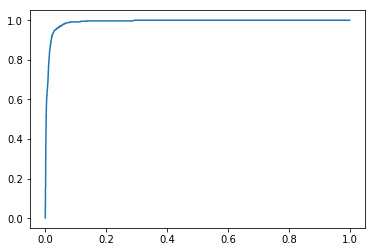

In [37]:
plt.plot(fpr, tpr)

In [38]:
test_predictions = test_predictions_tmp[int(-len(test_predictions_tmp)/EPOCHS):]

In [39]:
unpacked_test_predictions = []

In [40]:
for i in range(len(test_predictions)):
    d = torch.softmax(test_predictions[i], dim = 1).numpy()
    for e in d:
        unpacked_test_predictions.append(e[1])
unpacked_test_predictions = np.array(unpacked_test_predictions)

In [41]:
(test_y == unpacked_test_predictions.round()).sum() / len(test_y)

0.7290909090909091

In [42]:
fpr, tpr, threshold = metrics.roc_curve(test_y, unpacked_test_predictions)
auc_test = metrics.auc(fpr, tpr)
PRF1 = metrics.precision_recall_fscore_support(test_y, unpacked_test_predictions.round(), average='binary')[:3]    
print(auc_test)
print(PRF1)

0.5052275483088672
(0.15625, 0.18072289156626506, 0.16759776536312848)


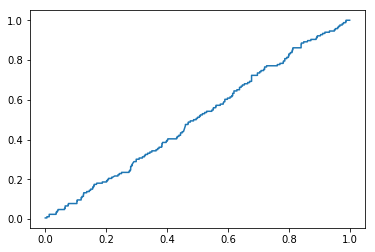

In [43]:
plt.plot(fpr, tpr)

In [44]:
test_predictions_bal = test_bal_predictions_tmp[int(-len(test_bal_predictions_tmp)/EPOCHS):]

In [45]:
unpacked_test_predictions_bal = []

In [46]:
for i in range(len(test_predictions_bal)):
    d = torch.softmax(test_predictions_bal[i], dim = 1).numpy()
    for e in d:
        unpacked_test_predictions_bal.append(e[1])
unpacked_test_predictions_bal = np.array(unpacked_test_predictions_bal)

In [47]:
fpr, tpr, threshold = metrics.roc_curve(test_y_bal, unpacked_test_predictions_bal)
auc_test_bal = metrics.auc(fpr, tpr)
PRF1 = metrics.precision_recall_fscore_support(test_y_bal, unpacked_test_predictions_bal.round(), average='binary')[:3]    
print(auc_test_bal)
print(PRF1)

0.5195703125000001
(0.49122807017543857, 0.175, 0.2580645161290322)


In [48]:
from scipy import stats

print(stats.describe(unpacked_train_predictions))
print(stats.describe(unpacked_test_predictions))
print(stats.describe(unpacked_test_predictions_bal))

DescribeResult(nobs=4470, minmax=(5.1524843e-05, 0.99978846), mean=0.21664375, variance=0.09945742, skewness=1.5599913597106934, kurtosis=0.8593915728694452)
DescribeResult(nobs=1100, minmax=(0.00013252927, 0.99418056), mean=0.22413759, variance=0.07956627, skewness=1.3597716093063354, kurtosis=0.6033691605789393)
DescribeResult(nobs=320, minmax=(0.00024951427, 0.9816472), mean=0.2191365, variance=0.080991715, skewness=1.3720049858093262, kurtosis=0.5948175694742557)


In [49]:
train_acc_ = np.array([x.numpy() for x in train_acc_])
test_acc_ = np.array([x.numpy() for x in test_acc_])
test_bal_acc_ = np.array([x.numpy() for x in test_bal_acc_])

In [50]:
train_loss_ = np.array(train_loss_)
test_loss_ = np.array(test_loss_)
test_bal_loss_ = np.array(test_bal_loss_)

In [51]:
np.save('../data/train_acc', train_acc_)
np.save('../data/test_acc_', test_acc_)
np.save('../data/test_bal_acc_', test_bal_acc_)
np.save('../data/train_loss_', train_loss_)
np.save('../data/test_loss_', test_loss_)
np.save('../data/test_bal_loss_', test_bal_loss_)